In [1]:
from differences import ATTgt
from matplotlib import pyplot as plt
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
from panel_utilities import get_value_variable_names, convert_weekly_panel_to_biweekly_panel, prepare_df_for_DiD
from stats_utilities import select_controls, test_balance
from figure_utilities import aggregate_by_event_time_and_plot, aggregate_by_time_and_plot
import pandas as pd



# Store paths.
analysis='group_3_crimes_500m'
INPUT_DATA = "../../data/03_cleaned/crime_analysis_monthly.parquet"
OUTPUT_FIGURES = f"../../output/{analysis}/figures"
OUTPUT_TABLES = f"../../output/{analysis}/tables"


# Read restricted sample panel dataset into memory.
df = pd.read_parquet(INPUT_DATA)

In [2]:
# Convert weekly panel to biweekly panel.
treatment_date_variable = 'latest_docket_month'
df = df.dropna(subset=treatment_date_variable)
# df = convert_weekly_panel_to_biweekly_panel(df, treatment_date_variable, analysis)

# Generate value vars list and month to int dictionaries.
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

In [3]:
covariates_exploration_df = select_controls(df=df, analysis=analysis,
                                            treatment_date_variable=treatment_date_variable,
                                            output_directory=OUTPUT_TABLES)
covariates_exploration_df

Dependent Variable  \
                                                                                                                  
                                                 \emph{Independent Variable}                                      
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_3_crimes_500m        2.408600e-77   
                                                 pre_treatment_change_in_group_3_crimes_500m       2.384115e-06   
Panel B: Census Tract Characteristics            frac_coll_plus2010                                2.414605e-01   
                                                 job_density_2013                                  2.001446e-17   
                                                 med_hhinc2016                                     3.998576e-01   
                                                 poor_share2010                                    1.979796e-01   
                                                 popdensity2010                                    1.350318e-17   
Panel C: Case Initiation                         for_cause                                         4.315506e-01   
                                                 no_cause                                          2.952548e-01   
                                                 non_payment                                       9.757771e-01   
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                          5.356761e-01   
                                                 hasAttyP                                          3.714776e-06   
                                                 isEntityD                                         1.678531e-01   
                                                 isEntityP                                         3.260601e-03   

                                                                                                            
                                                                                                            
                                                 \emph{Independent Variable}                                
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_3_crimes_500m   2.100044e-02  
                                                 pre_treatment_change_in_group_3_crimes_500m  3.359487e-02  
Panel B: Census Tract Characteristics            frac_coll_plus2010                           2.196947e-01  
                                                 job_density_2013                             1.019090e-01  
                                                 med_hhinc2016                                4.881476e-02  
                                                 poor_share2010                               9.587528e-01  
                                                 popdensity2010                               2.446323e-03  
Panel C: Case Initiation                         for_cause                                    1.210370e-09  
                                                 no_cause                                     9.538294e-01  
                                                 non_payment                                  3.799494e-08  
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                     1.768454e-03  
                                                 hasAttyP                                     3.747346e-04  
                                                 isEntityD                                    6.440755e-02  
                                                 isEntityP                                    4.931512e-07

In [4]:
balance_table, pre_treatment_covariates = test_balance(df, analysis, covariates_exploration_df, OUTPUT_TABLES)
balance_table

\
                                              Cases Won by Plaintiff   
Panel A Total Group 3 Incidents, 2017                     122.933460   
        $\Delta$ Group 3 Incidents, 2017-2019             -15.247782   
Panel B Job density, 2013                               17324.753036   
        Population density, 2010                        23285.588974   
Panel D Plaintiff has attorney                              0.875158   
        Plaintiff is entity                                 0.805450   

                                              Difference in Cases Won by Defendant  \
                                                                        Unweighted   
Panel A Total Group 3 Incidents, 2017                                     5.742600   
        $\Delta$ Group 3 Incidents, 2017-2019                            -2.091196   
Panel B Job density, 2013                                              2509.701466   
        Population density, 2010                                       1452.046732   
Panel D Plaintiff has attorney                                           -0.039492   
        Plaintiff is entity                                              -0.066862   

                                                                         \
                                                   \emph{p}    Weighted   
Panel A Total Group 3 Incidents, 2017          2.100044e-02   -2.224067   
        $\Delta$ Group 3 Incidents, 2017-2019  3.359487e-02    0.244347   
Panel B Job density, 2013                      1.019090e-01 -274.576741   
        Population density, 2010               2.446323e-03 -412.949477   
Panel D Plaintiff has attorney                 3.747346e-04   -0.017670   
        Plaintiff is entity                    4.931512e-07   -0.016960   

                                                         
                                               \emph{p}  
Panel A Total Group 3 Incidents, 2017          0.304321  
        $\Delta$ Group 3 Incidents, 2017-2019  0.790378  
Panel B Job density, 2013                      0.852869  
        Population density, 2010               0.279390  
Panel D Plaintiff has attorney                 0.096240  
        Plaintiff is entity                    0.115939

In [5]:
# Generate indicators for missing data.

# missing_indicators = add_missing_indicators(df, ['rent_twobed2015'], pre_treatment_covariates)

# Prepare df for use with the differences package.
df = df.reset_index()
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        missing_indicators=[],
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)

In [6]:
# Run DiD without conditioning on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, base_period='universal')
result = att_gt.fit(formula=analysis, control_group='not_yet_treated', n_jobs=-1)

Computing ATTgt [workers=34]  100%|████████████████████| 3772/3772 [00:05<00:00, 641.60it/s] 


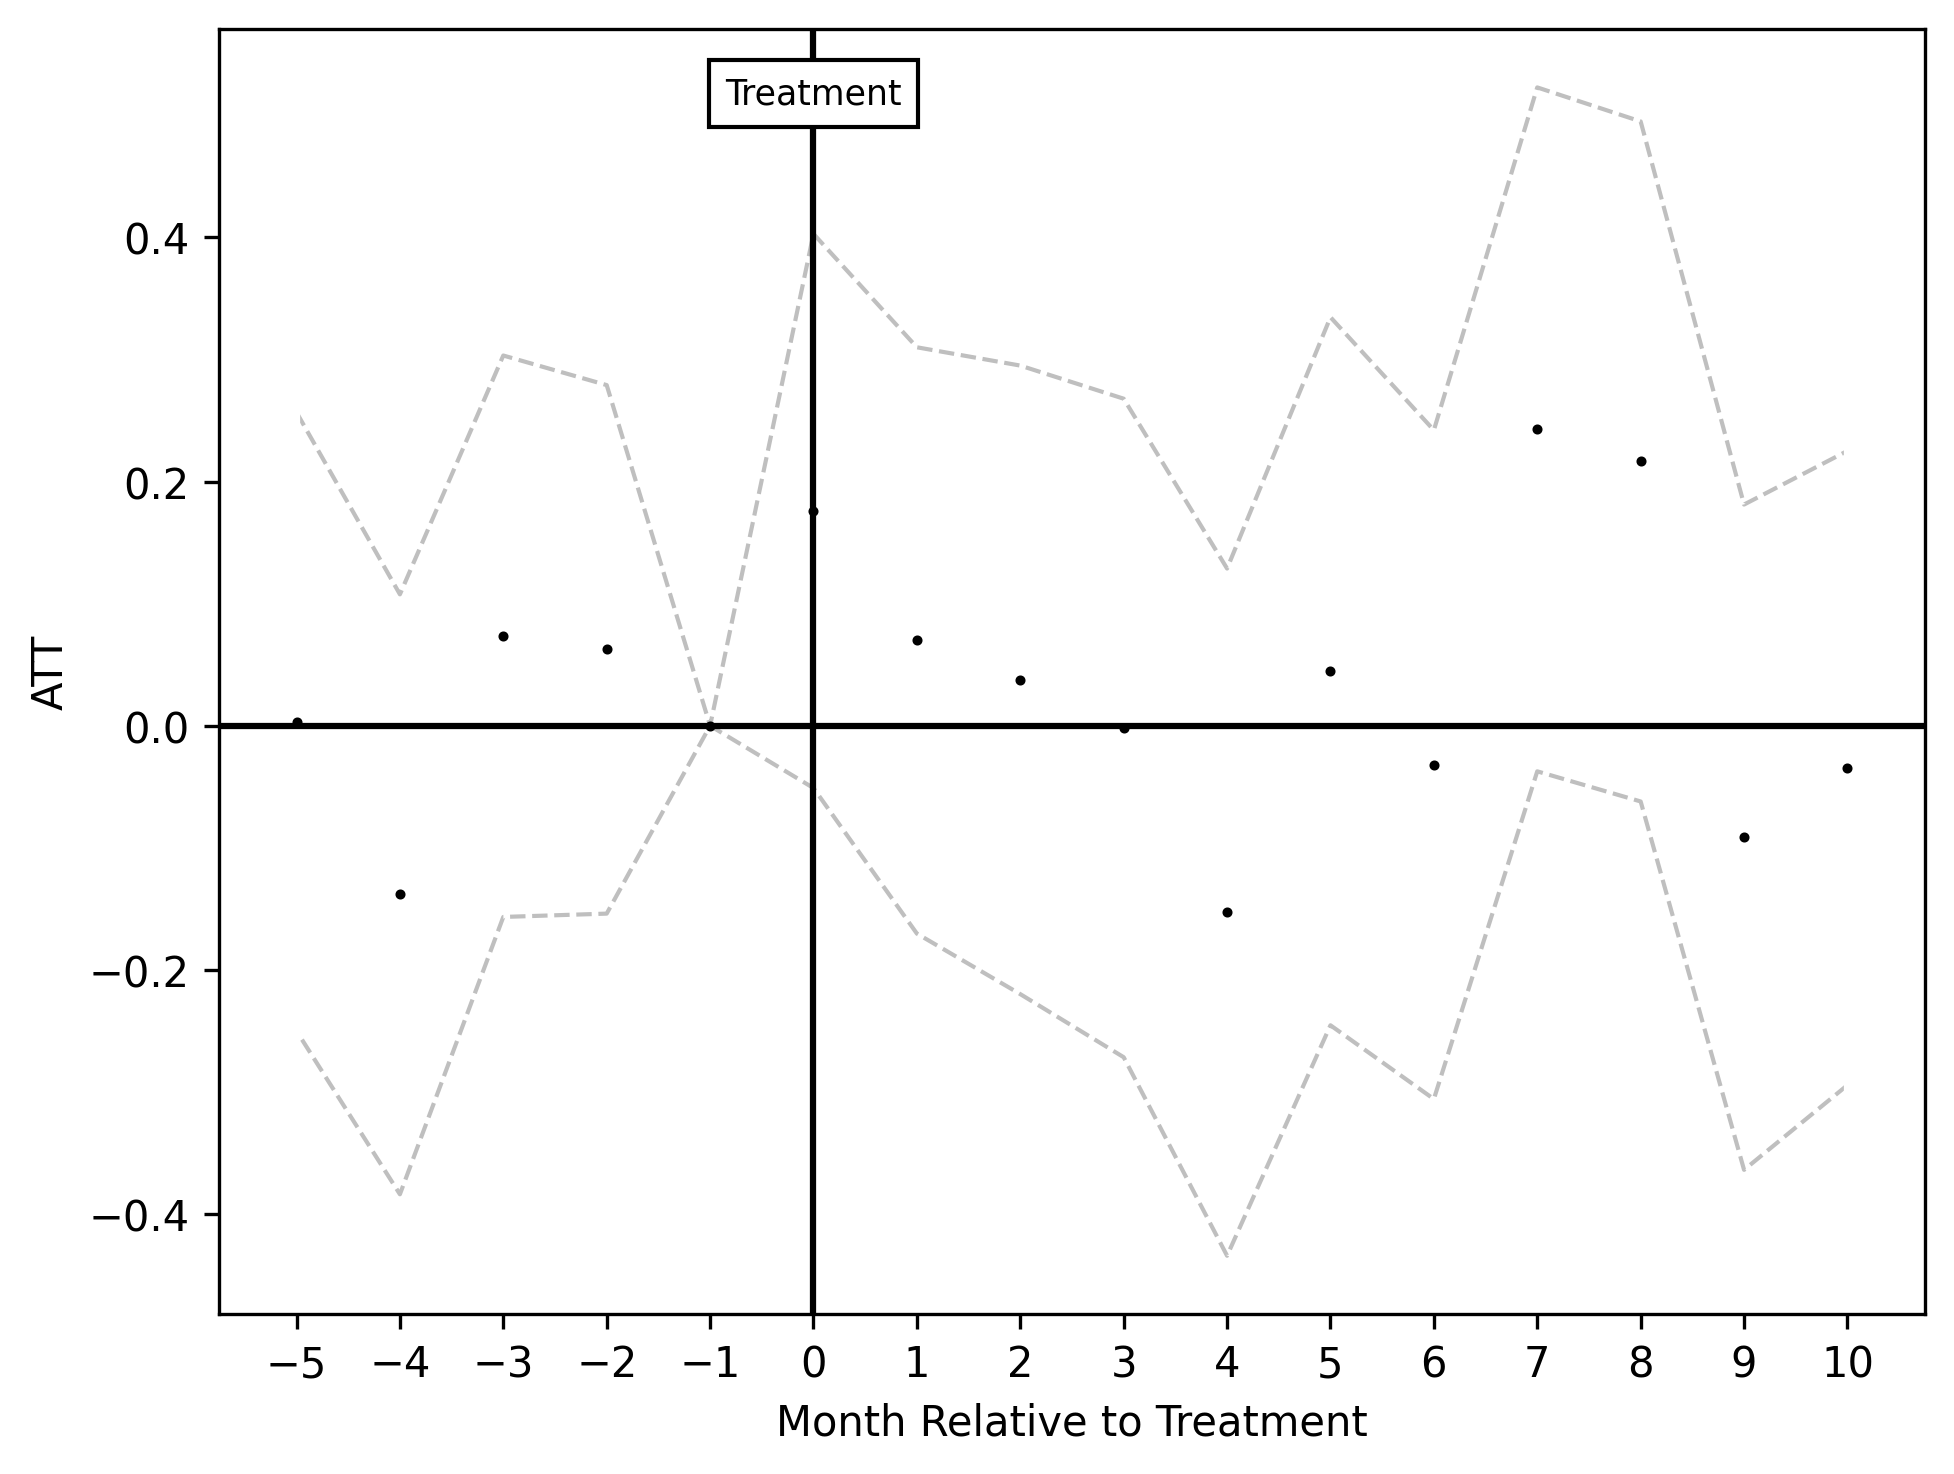

In [7]:
# Plot unconditional ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_unconditional_event_study_long_horizon.png",
                                 start_period=-5, end_period=10,
                                 title="",
                                 treatment_month_variable=treatment_date_variable, df=df)

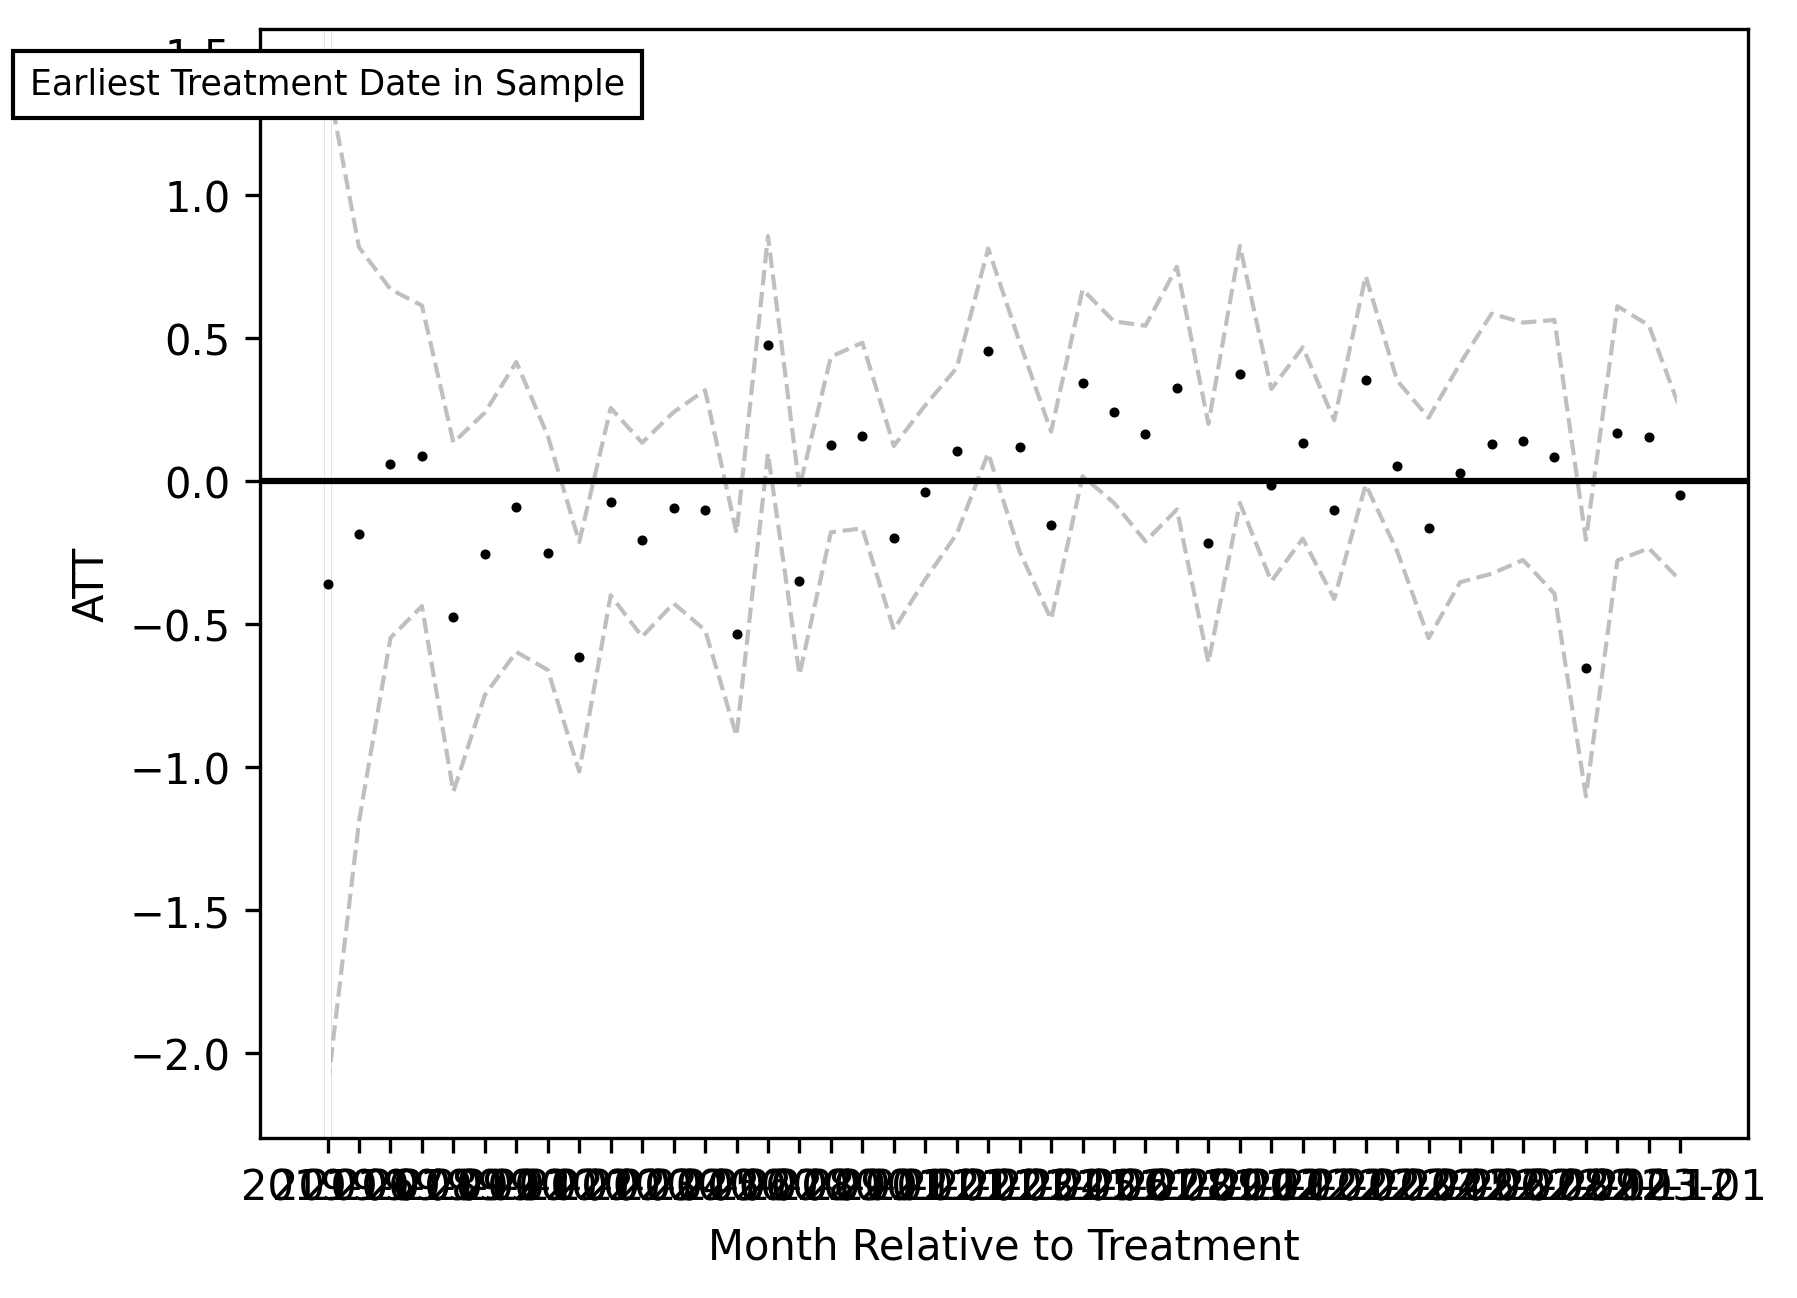

In [8]:
# Plot unconditional ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_unconditional_time.png",
                           title="")

In [9]:
# Run DiD conditional on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='M', base_period='universal')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt.fit(formula=formula, control_group='not_yet_treated', n_jobs=-1, progress_bar=True)

Computing ATTgt [workers=34]  100%|████████████████████| 3772/3772 [00:09<00:00, 406.86it/s]


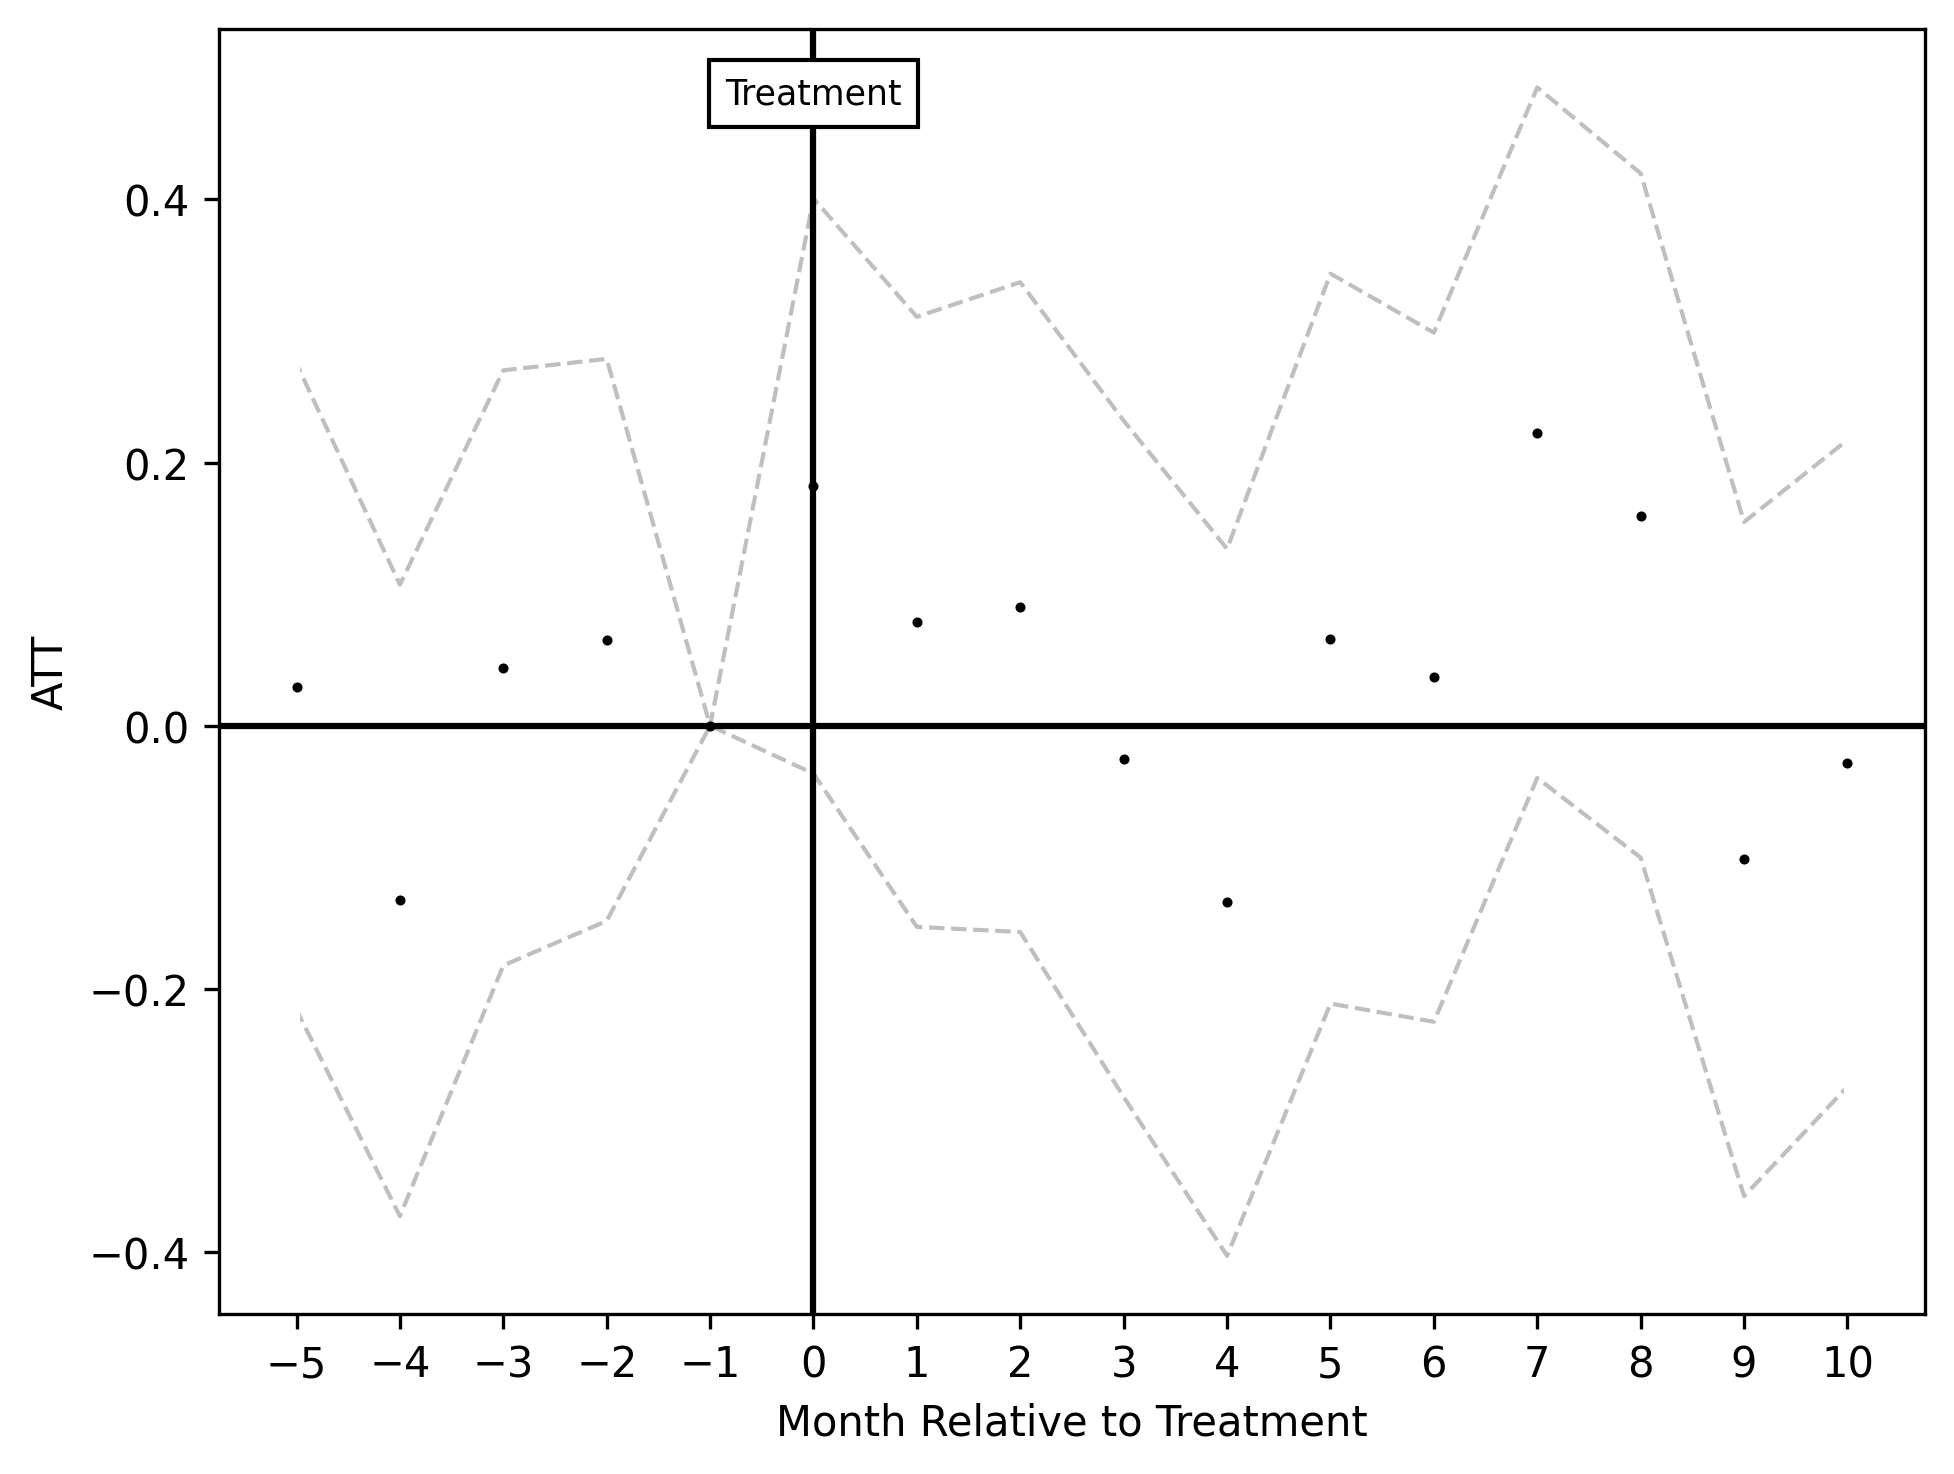

In [10]:
# Plot D.R. ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_long_horizon.png", start_period=-5,
                                 end_period=10,
                                 title="",
                                 treatment_month_variable=treatment_date_variable, df=df)

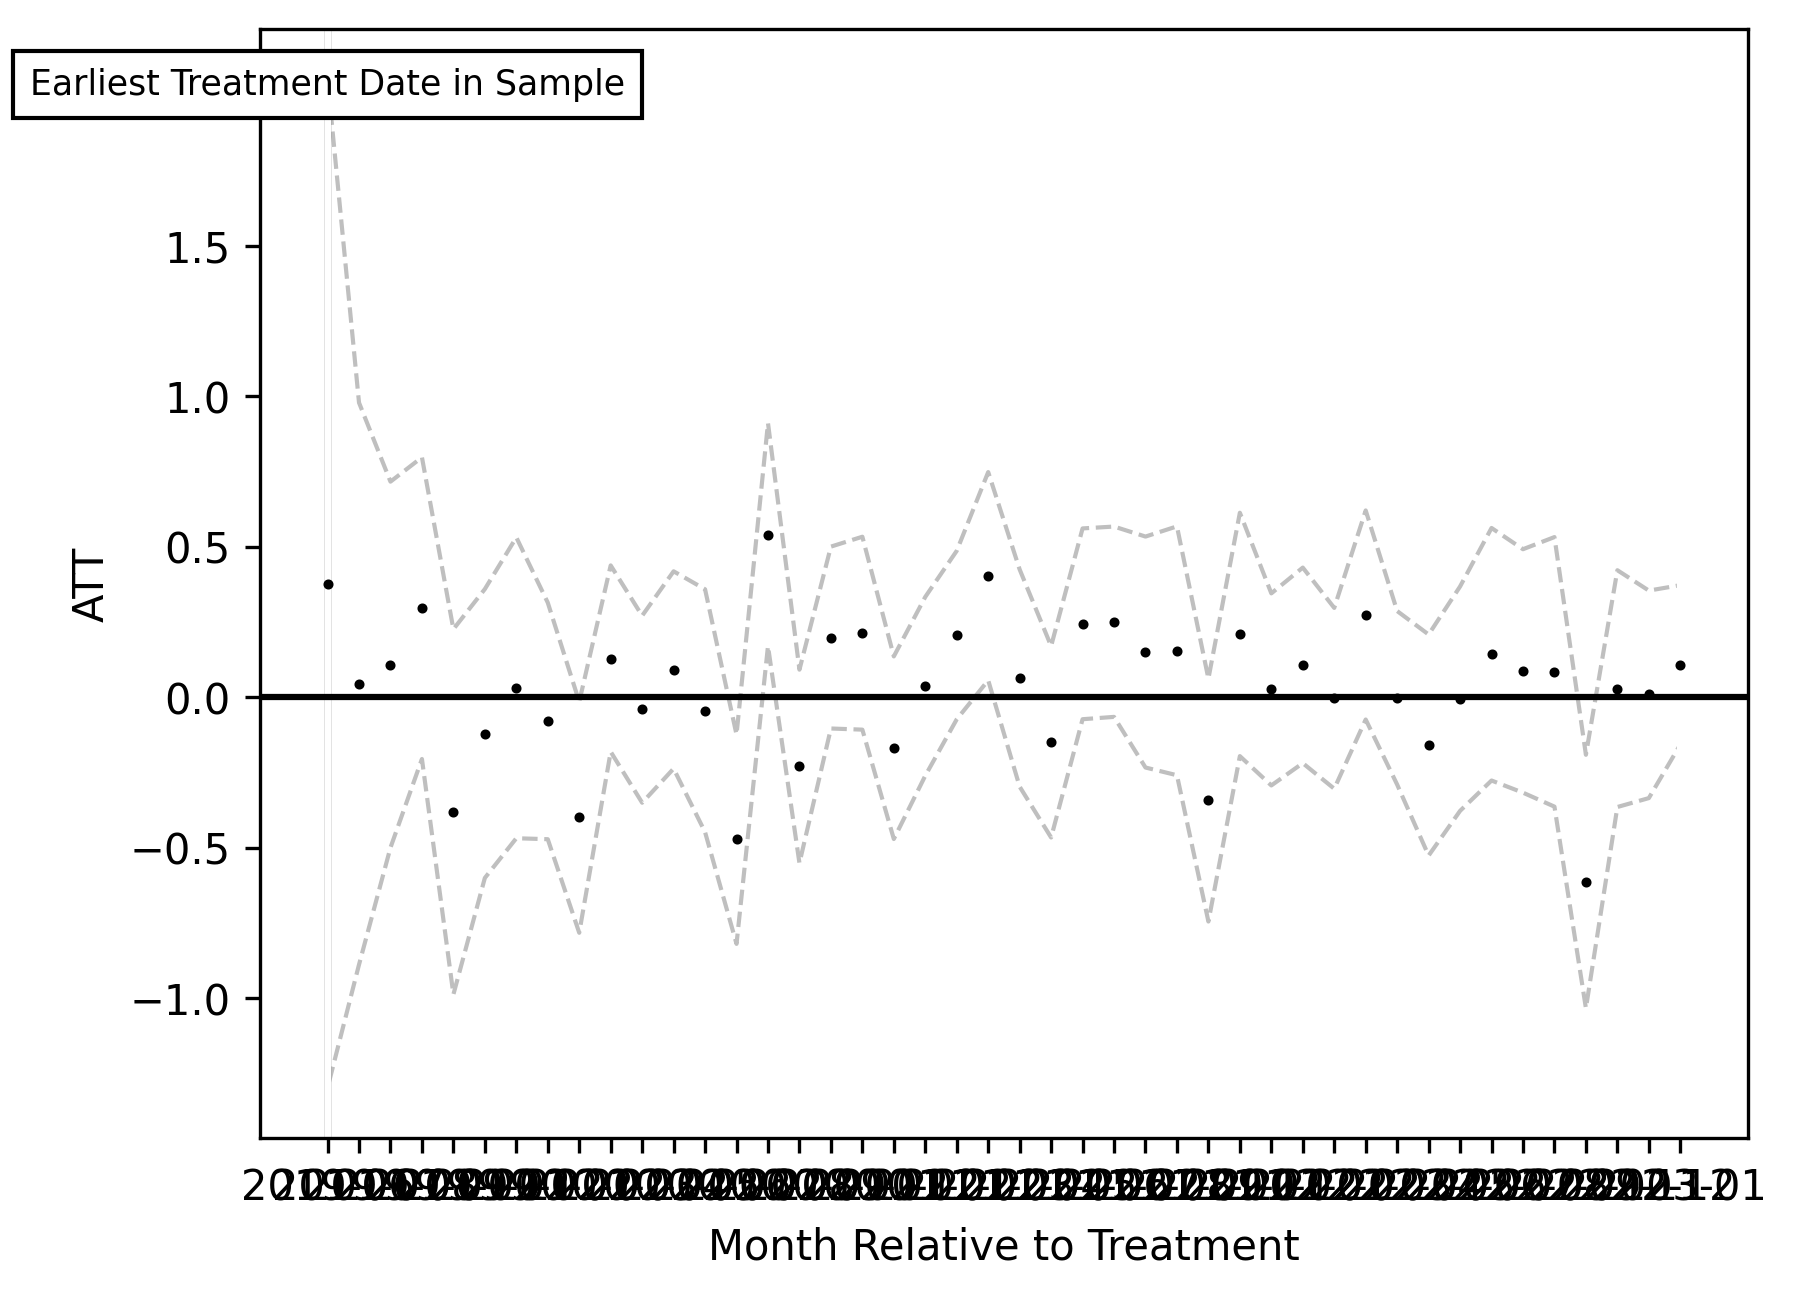

In [11]:
# Plot D.R. ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_dr_time.png",
                           title="")